In [1]:
import f3dasm
import numpy as np
from numdifftools import Gradient
from dataclasses import dataclass
import copy
from typing import Tuple

2022-11-28 12:27:22.681715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 12:27:22.831089: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 12:27:23.509083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:/usr/local/cuda-11.1/lib64
2022-11-28 12:27:23.509146: W ten

In [2]:
dimensionality = 2
design = f3dasm.make_nd_continuous_design(bounds=np.tile([-1.,1.], (dimensionality,1)), dimensionality=dimensionality)
function = f3dasm.functions.Levy(dimensionality=dimensionality, scale_bounds=design.get_bounds())

In [3]:
x = np.array([0.4,0.3])
h=1e-8

In [4]:
function.dfdx(x)

array([328.80667646,  10.5006031 ])

In [5]:
h = np.zeros(x.shape)
h[1] = 1e-8
x+h

array([0.4       , 0.30000001])

In [6]:
def central_differences(x: float, h: float):
    g = (function(x+h)-function(x-h))/(2*1e-8)
    return g.ravel().tolist()

In [7]:
grad = []
for index, param in enumerate(x):
    # print(f"{index} {param}")
    h = np.zeros(x.shape)
    h[index] = 1e-8
    grad.append(central_differences(x=param, h=h))

grad = np.array(grad)
grad

array([[328.80667646],
       [ 10.5006031 ]])

In [8]:
@dataclass
class Momentum_Exercise_Parameters(f3dasm.OptimizerParameters):
   """Example of hyperparameters"""

   momentum: float = 0.9
   learning_rate: float = 1e-4

class Momentum_Exercise(f3dasm.Optimizer):
   """Example of implement your own optimizer"""

   parameter: Momentum_Exercise_Parameters = Momentum_Exercise_Parameters()

   def init_parameters(self):
      """Set the initialization parameters. This could be dynamic or static hyperparameters."""
      self.velocity: np.ndarray = np.zeros(self.data.design.get_number_of_input_parameters())

   def update_step(self, function: f3dasm.Function) -> Tuple[np.ndarray, np.ndarray]:
      """Custom update step for your own optimizer

      Parameters
      ----------
      function
         objective function that is being optimized

      Returns
      -------
         tuple of resulting input and output parameter
      """

      x = self.data.get_input_data().iloc[-1].to_numpy()

      self.velocity = self.parameter.momentum * self.velocity  + self.parameter.learning_rate * function.dfdx(x)

      x_update = x - self.velocity

      x_update = np.atleast_2d(self._force_bounds(x_update))

      y_update = function(x_update)

      return x_update, y_update

In [9]:
grid_sampler = f3dasm.sampling.LatinHypercube(design=design, seed=42)
samples = grid_sampler.get_samples(numsamples=123)

Optimizing for 100 iterations with Momentum_Exercise


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{1}$'>)

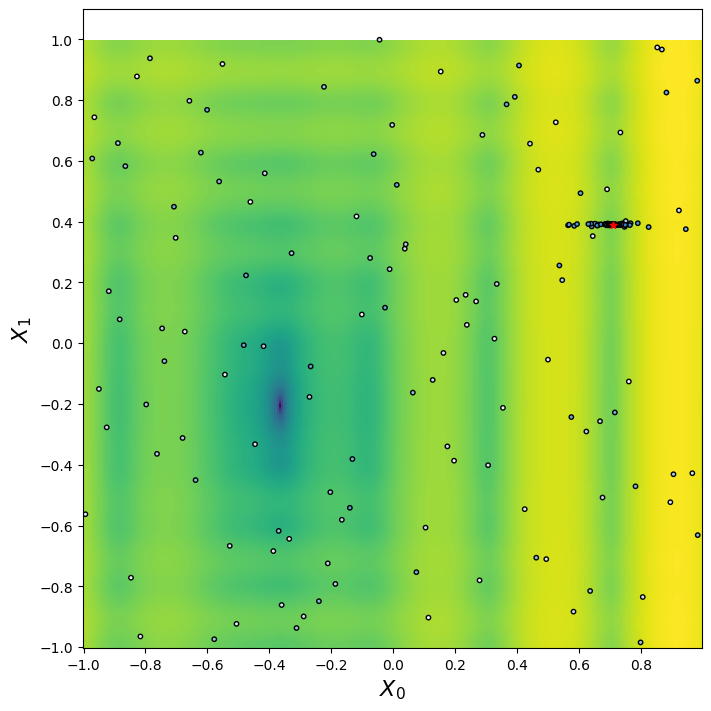

In [10]:
# We can put them in a dictionary if we want
iterations = 100

mon_optiizer = Momentum_Exercise(data=copy.copy(samples))
mon_optiizer.iterate(iterations,function)
mon_optiizer_data = mon_optiizer.extract_data()

function.plot_data(data=mon_optiizer_data, domain=design.get_bounds())

In [11]:
adam_optimizer = f3dasm.optimization.RandomSearch(data=copy.copy(samples))
adam_optimizer.update_step(function)

(array([[0.34503691, 0.50474906]]), array([[12.17636655]]))

In [12]:
x = samples.get_input_data().iloc[-1].to_numpy()
x

array([0.82545045, 0.38238354])

In [13]:
velocity: np.ndarray = np.zeros(samples.design.get_number_of_input_parameters())
momentum = 0.9
learning_rate = 1e-3
velocity

array([0., 0.])

In [14]:
velocity = np.array([0.1,1.0])

In [15]:
momentum * velocity

array([0.09, 0.9 ])

In [16]:
learning_rate * function.dfdx(x)

array([ 0.77801546, -0.00752232])

In [17]:
momentum * velocity  + learning_rate * function.dfdx(x)

array([0.86801546, 0.89247768])

In [18]:
function.dfdx(x)*learning_rate + momentum

array([1.67801546, 0.89247768])

In [19]:
velocity = momentum * velocity  + learning_rate * function.dfdx(x)
velocity

array([0.86801546, 0.89247768])

In [20]:
x - velocity

array([-0.04256502, -0.51009413])

In [21]:
x = np.array([-1.1, 0.8])

In [22]:
x.clip(min=design.get_bounds()[:,0], max=design.get_bounds()[:,1])

array([-1. ,  0.8])

In [23]:
design.get_bounds()[:,1]

array([1., 1.])